# Pairs Trading Strategy


Pairs trading is a nice example of a strategy based on mathematical analysis. The principle is as follows:

Let's say you have a pair of securities X and Y that have some underlying economic link. An example might be two companies that manufacture the same product, for example Pepsi and Coca Cola. You expect the spread (ratio or difference in prices) between these two to remain constant with time. However, from time to time, there might be a divergence in the spread between these two pairs. The divergence within a pair can be caused by temporary supply/demand changes, large buy/sell orders for one security, reaction for important news about one of the companies, and so on. When there is a temporary divergence between the two securities, i.e. one stock moves up while the other moves down, the pairs trade would be to short the outperforming stock and to long the underperforming one, betting that the "spread" between the two would eventually converge.

Pairs trading is a market neutral trading strategy enabling traders to profit from virtually any market conditions: uptrend, downtrend, or sideways movement. 

We'll start by constructing an artificial example.

In [4]:
import numpy as np
import pandas as pd

import statsmodels
from statsmodels.tsa.stattools import coint
# just set the seed for the random number generator
np.random.seed(107)

import matplotlib.pyplot as plt

## Explaining the Concept: We start by generating two fake securities.
We model X's daily returns by drawing from a normal distribution. Then we perform a cumulative sum to get the value of X on each day.

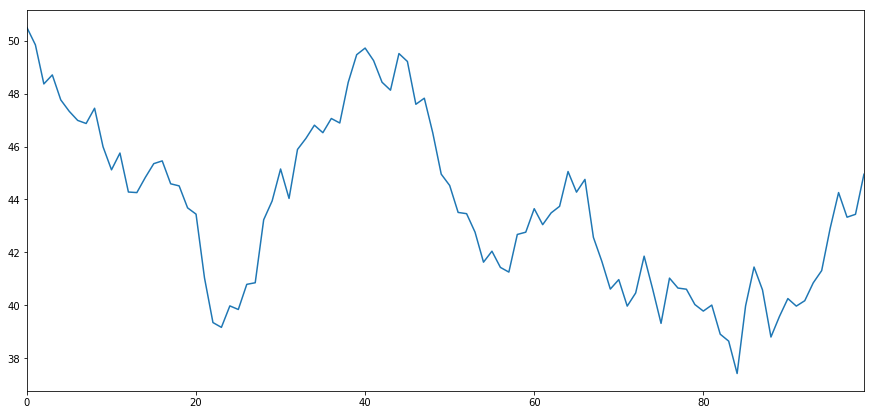

In [5]:
X_returns = np.random.normal(0, 1, 100) # Generate the daily returns
# sum them and shift all the prices up into a reasonable range
X = pd.Series(np.cumsum(X_returns), name='X') + 50
X.plot(figsize=(15,7))
plt.show()

Now we generate Y. Y is supposed to have a deep economic link to X, so the price of Y should vary pretty similarly. We model this by taking X, shifting it up and adding some random noise drawn from a normal distribution.

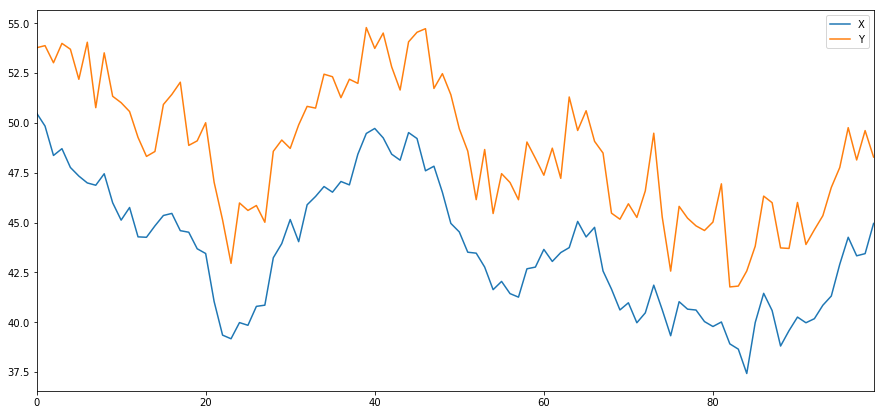

In [8]:
some_noise = np.random.normal(0, 1, 100)
Y = X + 5 + some_noise
Y.name = 'Y'
pd.concat([X, Y], axis=1).plot(figsize=(15,7))
plt.show()

## Cointegration

Cointegration, very loosely speaking,  is a "different" form of correlation. If two series are cointegrated, the ratio between them will vary around a mean. 

For pairs trading to work between two timeseries, the expected value of the ratio over time must converge to the mean, i.e. they should be cointegrated. 

The time series we conctructued above are cointegrated. We'll plot the ratio between the two now so we can see how this looks.

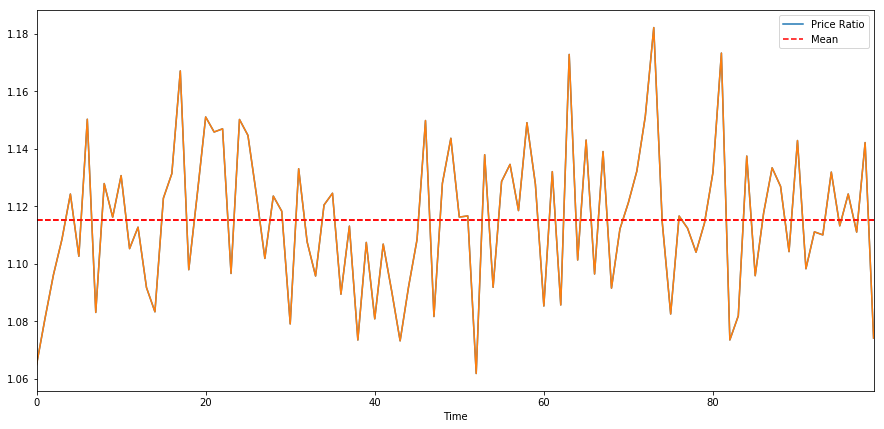

In [10]:
(Y/X).plot(figsize=(15,7)) # Plot the ratio
plt.axhline((Y/X).mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.legend(['Price Ratio', 'Mean'])
plt.show()

## Testing for Cointegration

There is a convenient test that lives in `statsmodels.tsa.stattools`. We should see a very low p-value, as we've artifically created two series that are as cointegrated as physically possible.

In [21]:
# compute the p-value of the cointegration test
# will inform us as to whether the ratio between the 2 timeseries is stationary
# around its mean
score, pvalue, _ = coint(X,Y)
print pvalue

1.81864477307e-17


### Correlation vs. Cointegration

Correlation and cointegration, while theoretically similar, are not the same. To demonstrate this, we'll show examples of series that are correlated, but not cointegrated, and vice versa. To start let's check the correlation of the series we just generated.

In [12]:
X.corr(Y)

0.95061486935823869

That's very high, as we would expect. But how would two series that are correlated but not cointegrated look? 

### Correlation Without Cointegration

A simple example is two series that just diverge.

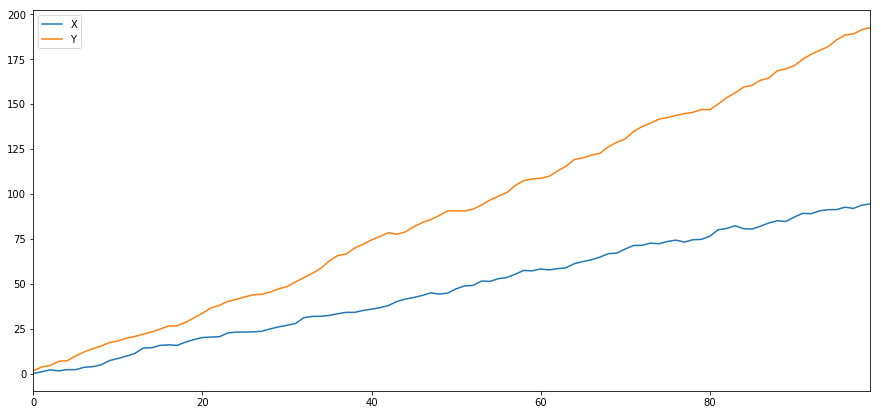

In [15]:
X_returns = np.random.normal(1, 1, 100)
Y_returns = np.random.normal(2, 1, 100)

X_diverging = pd.Series(np.cumsum(X_returns), name='X')
Y_diverging = pd.Series(np.cumsum(Y_returns), name='Y')

pd.concat([X_diverging, Y_diverging], axis=1).plot(figsize=(15,7))
plt.show()

In [16]:
print 'Correlation: ' + str(X_diverging.corr(Y_diverging))
score, pvalue, _ = coint(X_diverging,Y_diverging)
print 'Cointegration test p-value: ' + str(pvalue)

Correlation: 0.997652782192
Cointegration test p-value: 0.25829058313


### Cointegration Without Correlation

A simple example of this case is a normally distributed series and a square wave.

In [17]:
Y2 = pd.Series(np.random.normal(0, 1, 1000), name='Y2') + 20
Y3 = Y2.copy()

In [18]:
# Y2 = Y2 + 10
Y3[0:100] = 30
Y3[100:200] = 10
Y3[200:300] = 30
Y3[300:400] = 10
Y3[400:500] = 30
Y3[500:600] = 10
Y3[600:700] = 30
Y3[700:800] = 10
Y3[800:900] = 30
Y3[900:1000] = 10

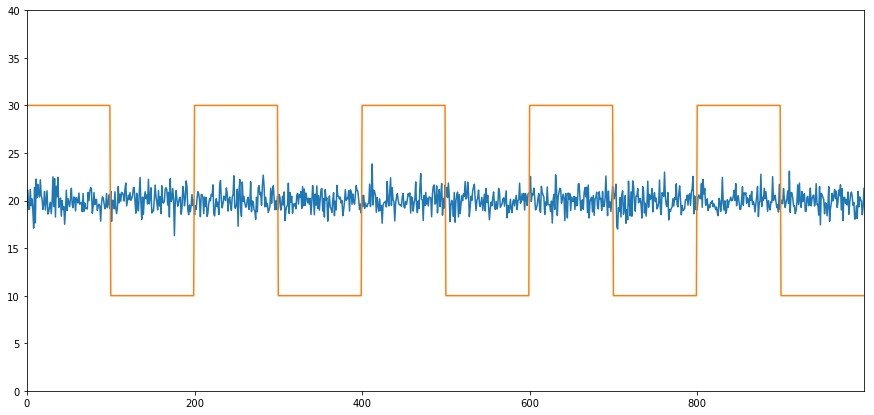

In [19]:
Y2.plot(figsize=(15,7))
Y3.plot()
plt.ylim([0, 40])
plt.show()

In [20]:
# correlation is nearly zero
print 'Correlation: ' + str(Y2.corr(Y3))
score, pvalue, _ = coint(Y2,Y3)
print 'Cointegration test p-value: ' + str(pvalue)

Correlation: 0.00753955971676
Cointegration test p-value: 0.0


Sure enough, the correlation is incredibly low, but the p-value shows perfect cointegration.

## How to make a pairs trade?

Because two cointegrated time series (such as X and Y above) drift towards and apart from each other, there will be times when the distance is high and times when the distance is low. We make a pairs trade by maintaining a hedged position across X and Y. That means buying one security and selling another. This way, if both securities go down together or go up together, we neither make nor lose money - This means we are market neutral. 

We make money on the ratio of the two reverting to the mean,i.e when they move in directions opposite to each other. In order to do this we'll watch for when X and Y are far apart, then short Y and long X. Similarly we'll watch for when they're close together, and long Y and short X.

* **Going Long the Ratio**
This is when the ratio is small and we expect it to become larger. In the above example, we place a bet on this by longing Y and shorting X.

* **Going Short the Ratio**
This is when the ratio is large and we expect it to become smaller. In the above example, we place a bet on this by shorting Y and longing X.

### What is a hedged position?

Because you'd like to protect yourself from bad markets, often times short sales will be used to hedge long investments. Because a short sale makes money if the security sold loses value, and a long purchase will make money if a security gains value, one can long parts of the market and short others. That way if the entire market falls off a cliff, we'll still make money on the shorted securities and hopefully break even. In the case of two securities we'll call it a hedged position when we are long on one security and short on the other.


## Finding real securities that behave like this

The best way to do this is to start with securities you suspect may be cointegrated and perform a statistical test. If you just run statistical tests over all pairs, you'll fall prey to multiple comparison bias.

** Multiple comparisons bias** is the increased chance to incorrectly generate a significant p-value when many tests are run. If 100 tests are run on random data, we should expect to see 5 p-values below 0.05 on expectation. If you are comparing $n$ securities for co-integration, you will perform $n(n-1)/2$ comparisons, and you should expect to see many incorrectly significant p-values, and this will increase as you increase $n$. To avoid this, pick a small number of pairs you have reason to suspect might be cointegrated and test each individually. This will result in less exposure to multiple comparisons bias.

Let's try now try to find some securities that display cointegration. Below we scan through a list of securities and test for cointegration between all pairs. It returns a cointegration test score matrix, a p-value matrix, and any pairs for which the p-value was less than 0.05. **This method is prone to  multiple comparison bias and in practice the securities should be subject to a second verification step**. Let's ignore this for the sake of this example.

In [22]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

## Looking for Cointegrated Pairs of Alternative Energy Securities
Let's look through a set of tech company stocks to see if any of them are cointegrated. 

**Note** We include the market benchmark (*SPX*) in our data. This is because the market drives the movement of so many securities that you often times might find two seemingingly cointegrated securities, but in reality they are not cointegrated and just both conintegrated with the market. This is known as a confounding variable and it is important to check for market involvement in any relationship you find.

In [24]:
import auquanToolbox.dataloader as dl

start = '2012-01-01'
end = '2016-12-31'

m = ['NVDA','ADBE','SYMC','YHOO','EBAY','BSX','QCOM','TXN','AMAT','GLW','HPQ','JNPR','AMD','IBM','SPX']
data = dl.load_data_nologs('nasdaq', m , start, end)
prices = data['ADJ CLOSE']

C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\matplotlib\__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Reading NVDA
Reading ADBE
Reading SYMC
Reading YHOO
Reading EBAY
Reading BSX
Reading QCOM
Reading TXN
Reading AMAT
Reading GLW
Reading HPQ
Reading JNPR
Reading AMD
Reading IBM
Reading SPX
Data ends before End Date. Filling rest of the data for SPX


In [26]:
prices.head()

,NVDA,ADBE,SYMC,YHOO,EBAY,BSX,QCOM,TXN,AMAT,GLW,HPQ,JNPR,AMD,IBM,SPX
2011-12-29,13.002133,28.309999,11.544197,16.129999,12.777777,5.33,48.533614,25.711720,9.538258,11.550222,10.175025,19.681925,5.34,163.576288,1263.020020
2011-12-30,12.899754,28.270000,11.507432,16.129999,12.765152,5.34,48.400890,25.510163,9.565051,11.488266,10.230626,19.605080,5.40,161.555537,1257.599976
2012-01-03,13.067283,28.570000,11.603021,16.290001,13.190236,5.36,48.905250,26.079782,9.556120,11.541371,10.572177,20.210235,5.48,163.681728,1277.060059
2012-01-04,13.216198,28.280001,11.580962,15.780000,12.693602,5.31,49.400763,25.913278,9.609706,11.656430,10.564233,19.931671,5.46,163.013990,1277.300049
2012-01-05,13.690865,28.480000,11.617727,15.640000,12.925084,5.34,49.604276,26.097309,9.672222,11.753788,10.524519,19.826009,5.46,162.240838,1281.060059


Now we'll run our method on the list and see if any pairs are cointegrated.

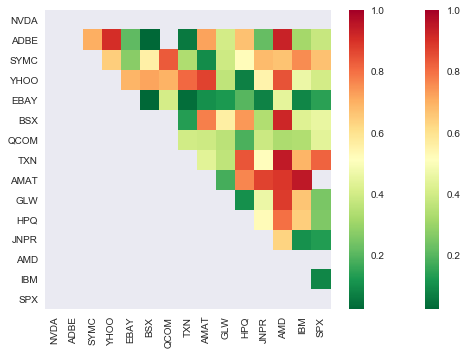

[('ADBE', 'BSX'), ('EBAY', 'BSX'), ('EBAY', 'TXN')]


In [29]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap

scores, pvalues, pairs = find_cointegrated_pairs(prices)
import seaborn
seaborn.heatmap(pvalues, xticklabels=m, yticklabels=m, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.95)
                )
plt.show()
print pairs

Looks like 'ADBE' and 'BSX' are cointegrated. Let's take a look at the prices to make sure there's nothing weird going on.

In [35]:
S1 = prices['ADBE']
S2 = prices['BSX']
score, pvalue, _ = coint(S1, S2)
pvalue

0.022676473850190511

We'll plot the ratio of the two series.

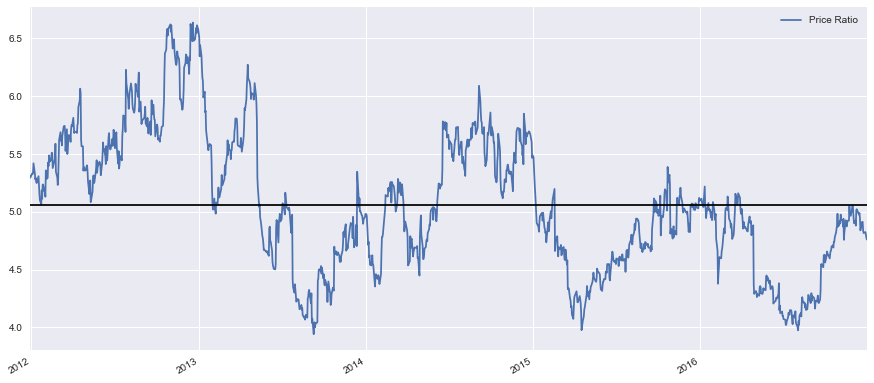

In [36]:
ratios = S1 / S2
ratios.plot(figsize=(15,7))
plt.axhline(ratios.mean(), color='black')
plt.legend(['Price Ratio'])
plt.show()

The absolute ratio isn't very useful in statistical terms. It is more helpful to normalize our signal by treating it as a z-score. 

### WARNING

In practice this is usually done to try to give some scale to the data, but this assumes some underlying distribution. Usually normal. Under a normal distribution, we would know that approximately 84% of all ratio values will be smaller. However, much financial data is not normally distributed, and one must be very careful not to assume normality, nor any specific distribution when generating statistics. It could be the case that the true distribution of ratios was very fat-tailed and prone to extreme values. This could mess up our model and result in large losses.

In [37]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

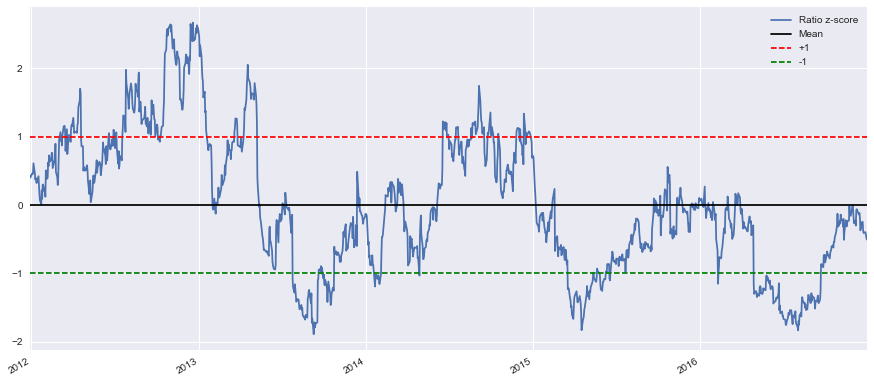

In [38]:
zscore(ratios).plot(figsize=(15,7))
plt.axhline(zscore(ratios).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Ratio z-score', 'Mean', '+1', '-1'])
plt.show()

### Simple Strategy: 
* Go "Long" the ratio whenever the z-score is below -1.0
* Go "Short" the ratio when the z-score is above 1.0
* Exit positions when the z-score approaches zero

This is just the tip of the iceberg, and only a very simplistic example to illustrate the concepts. 
* In practice you would want to compute a more optimal weighting for how many shares to hold for S1 and S2
* You would also want to trade using constantly updating statistics. In general taking a statistic over your whole sample size can be bad. For example, if the market is moving up, and both securities with it, then your average price over the last 3 years may not be representative of today. For this reason traders often use statistics that rely on rolling windows of the most recent data.

C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\ipykernel\__main__.py:10: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=60,center=False).mean()


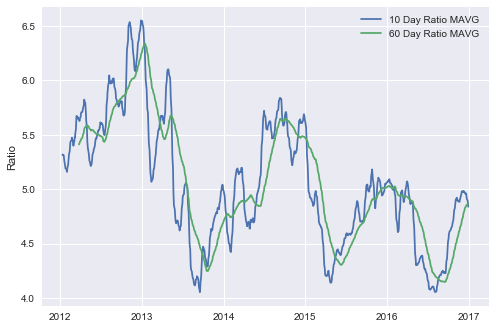

In [39]:
# Get the price ratio between the 2 stocks
ratios = S1 / S2
ratios.name = 'ratio'

# Get the 10 day moving average of the price ratio
ratios_mavg10 = pd.rolling_mean(ratios, window=10)
ratios_mavg10.name = 'ratio 10d mavg'

# Get the 60 day moving average
ratios_mavg60 = pd.rolling_mean(ratios, window=60)
ratios_mavg60.name = 'ratio 60d mavg'

plt.plot(ratios_mavg10.index, ratios_mavg10.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)

plt.legend(['10 Day Ratio MAVG', '60 Day Ratio MAVG'])

plt.ylabel('Ratio')
plt.show()

We can use the moving averages to compute the z-score of the ratio at each given time. This will tell us how extreme the ratio is and whether it's a good idea to enter a position at this time. Let's take a look at the z-score now.

C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=60,center=False).std()
  from ipykernel import kernelapp as app


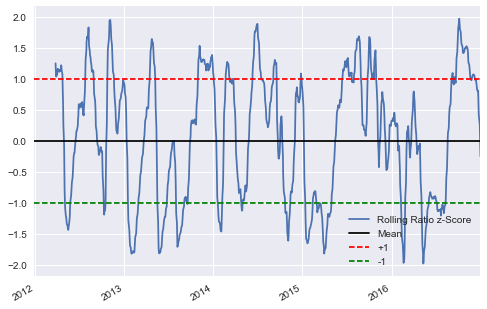

In [40]:
# Take a rolling 60 day standard deviation
std_60 = pd.rolling_std(ratios, window=60)
std_60.name = 'std 60d'

# Compute the z score for each day
zscore_60_10 = (ratios_mavg10 - ratios_mavg60)/std_60
zscore_60_10.name = 'z-score'
zscore_60_10.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

The z-score doesn't mean much out of context, let's plot it next to the prices to get an idea of what it looks like. We'll take the negative of the z-score because the ratios were all negative and that's kinda confusing.

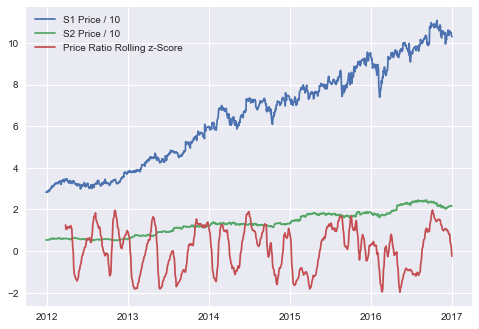

In [41]:
# Plot the prices scaled down along with the negative z-score
# just divide the stock prices by 10 to make viewing it on the plot easier
plt.plot(S1.index, S1.values/10)
plt.plot(S2.index, S2.values/10)
plt.plot(zscore_60_10.index, zscore_60_10.values)
plt.legend(['S1 Price / 10', 'S2 Price / 10', 'Price Ratio Rolling z-Score'])
plt.show()

In this notebook, we presented some simple introductory approaches. In practice one should use more sophisticated statistics, some of which are listed here.

* Augmented-Dickey Fuller test 
* Hurst exponent
* Half-life of mean reversion inferred from an Ornstein–Uhlenbeck process
* Kalman filters